In [57]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from sunbird.emulators import FCN, train
from sunbird.data import ArrayDataModule


In [58]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [59]:
%matplotlib inline

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/')
data_fn = Path(data_dir) / 'training_sets/tpcf/z0.5/yuan23_prior/cosmopower/tpcf.npy'
lhc_y = np.load(data_fn, allow_pickle=True,).item()

In [62]:
s = lhc_y['s']
lhc_y = lhc_y['multipoles']
lhc_x = pd.read_csv(data_dir / 'hod_params/yuan23/hod_params_yuan23_c000.csv')
lhc_x_names = list(lhc_x.columns)
lhc_x_names = [name.replace(' ', '').replace('#', '') for name in lhc_x_names]
lhc_x = lhc_x.values[:len(lhc_y),:]

In [63]:
# let's keep a few points for testing the model
lhc_train_y = lhc_y[:-3000]
lhc_train_x = lhc_x[:-3000]

lhc_test_y = lhc_y[-3000:]
lhc_test_x = lhc_x[-3000:]

In [64]:
train_mean = np.mean(lhc_y, axis=0)
train_std = np.std(lhc_y, axis=0)

train_mean_x = np.mean(lhc_x, axis=0)
train_std_x = np.std(lhc_x, axis=0)


In [65]:
batch_size = 256
num_workers = 2
validation_fraction = 0.2

data = ArrayDataModule(
    x=torch.Tensor(lhc_train_x),
    y=torch.Tensor(lhc_train_y), 
    val_fraction=validation_fraction,
    batch_size=batch_size,
    num_workers=num_workers,
)
data.setup()

In [66]:
model = FCN(
    n_input=data.n_input,
    n_output=data.n_output,
    n_hidden=[512, 512, 512, 512],
    dropout_rate=0., 
    learning_rate=1.e-3,
    act_fn='learned_sigmoid',
    loss='rmse',
    training=True,
    mean_output=train_mean,
    std_output=train_std,
    mean_input=train_mean_x,
    std_input=train_std_x,
)


In [11]:
val_loss, model, early_stop_callback = train.fit(
    model=model,
    data=data, 
    model_dir='emulate/',
    max_epochs=60,
)

[rank: 0] Seed set to 42


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: floppy. Use `wandb login --relogin` to force relogin


/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/holystore01/LABS/iaifi_lab/Lab/environments/carol ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/holystore01/LABS/iaifi_lab/Lab/environments/carol ...
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To 

┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ mlp  │ Sequential │  850 K │
└───┴──────┴────────────┴────────┘

Trainable params: 850 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 850 K                                                                                                
Total estimated model params size (MB): 3

Output()

/n/holystore01/LABS/iaifi_lab/Lab/environments/carol/envs/desilike/lib/python3.12/multiprocessing/popen_fork.py:66:
RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, 
so this will likely lead to a deadlock.
  self.pid = os.fork()

In [ ]:
print('best score = ', early_stop_callback.best_score.item())
print('stopped epoch = ', early_stop_callback.stopped_epoch)
print('wait count = ', early_stop_callback.wait_count)


best score =  0.5705341100692749
stopped epoch =  0
wait count =  0


In [67]:
# To load a model from a saved checkpoint:
checkpoint_fn = "tpcf_example/best-model-epoch=278-val_loss=0.09.ckpt"
model = FCN.load_from_checkpoint(checkpoint_fn,strict=True,)
model = model.to('cpu')

In [68]:
# and now let's test it
model.eval()
with torch.no_grad():
    pred_test_y  = model.get_prediction(torch.Tensor(lhc_test_x))
pred_test_y = pred_test_y.numpy()

Text(0, 0.5, '$r^2 \\xi(r)$')

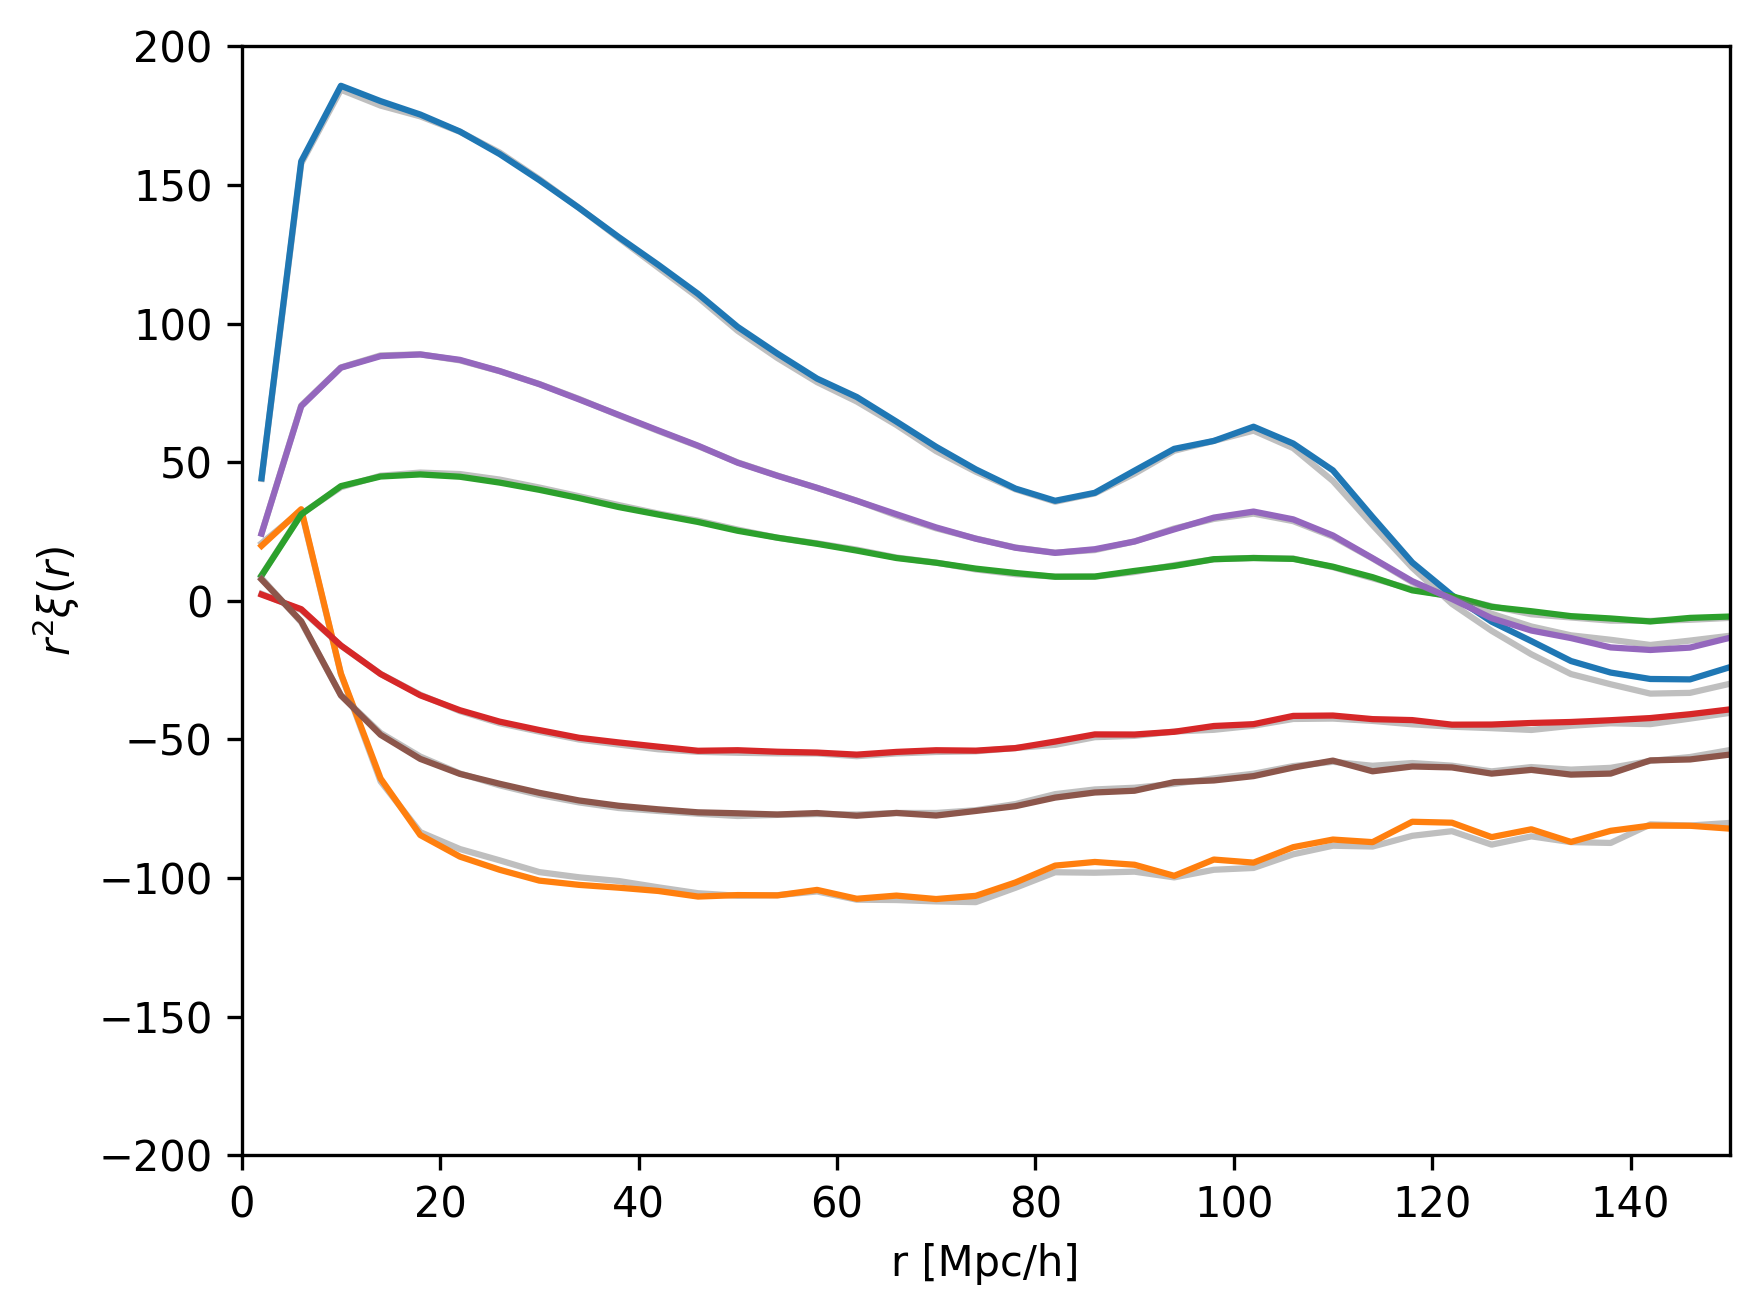

In [69]:

# let's plot some predictions vs truth
for i in range(3):
    plt.plot(
        s,
        s**2*pred_test_y[i,:50],
        color='gray',
        alpha=0.5,
    )
    plt.plot(
        s,
        s**2*pred_test_y[i,50:],
        color='gray',
        alpha=0.5,
    )

    plt.plot(s, s**2*lhc_test_y[i,:50], label='Observed')
    plt.plot(s, s**2*lhc_test_y[i,50:])


plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

In [70]:
# now load jax model
nn_model, nn_params = model.to_jax()

In [71]:
jax_pred, _  = nn_model.apply(
    nn_params,
    lhc_test_x,
)

Reading 1000 covariance files


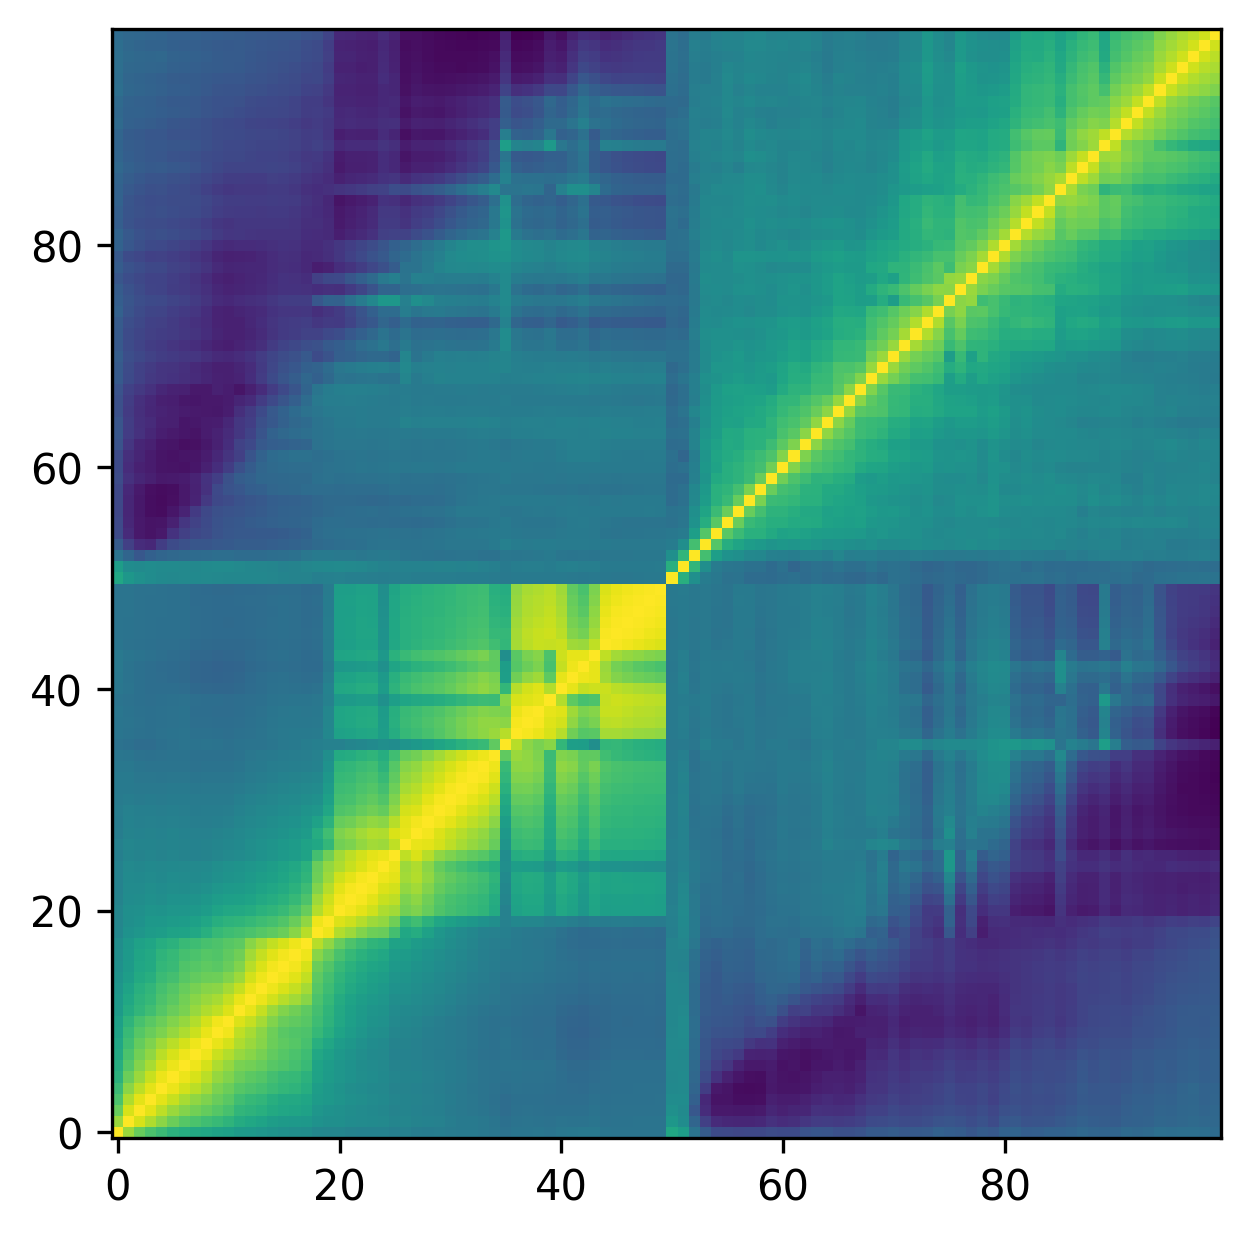

In [72]:
# and now let's compare the emulator errors to cosmic variance
from pycorr import TwoPointCorrelationFunction

covariance_path = data_dir / 'covariance/tpcf/z0.5/yuan23_prior/'
n_for_covariance = 1_000
covariance_files = list(covariance_path.glob('*.npy'))[:n_for_covariance]


print(f'Reading {len(covariance_files)} covariance files')
covariance_y = [
    TwoPointCorrelationFunction.load(file)[::4](ells=(0,2),).reshape(-1) for file in covariance_files
]

prefactor = 1./8.
covariance_matrix = prefactor * np.cov(np.array(covariance_y).T)

correlation_matrix = np.corrcoef(np.array(covariance_y).T)

plt.imshow(correlation_matrix, origin='lower')

In [73]:
emulator_error = (pred_test_y - lhc_test_y)/np.sqrt(np.diag(covariance_matrix))
q68 = np.quantile(emulator_error, [0.16, 0.84], axis=0)
q95 = np.quantile(emulator_error, [0.025, 0.975], axis=0)
q99 = np.quantile(emulator_error, [0.005, 0.995], axis=0)

<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:1: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_36074/3416532088.py:1: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(pred_test_y.shape[-1])), q95[0], q95[1], alpha=0.5, label='95\%',)
/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/tmp/ipykernel_36074/3416532088.py:2: SyntaxWarning: invalid escape sequence '\%'
  plt.fill_between(list(range(pred_test_y.shape[-1])), q68[0], q68[1], alpha=0.5, label='68\%',)


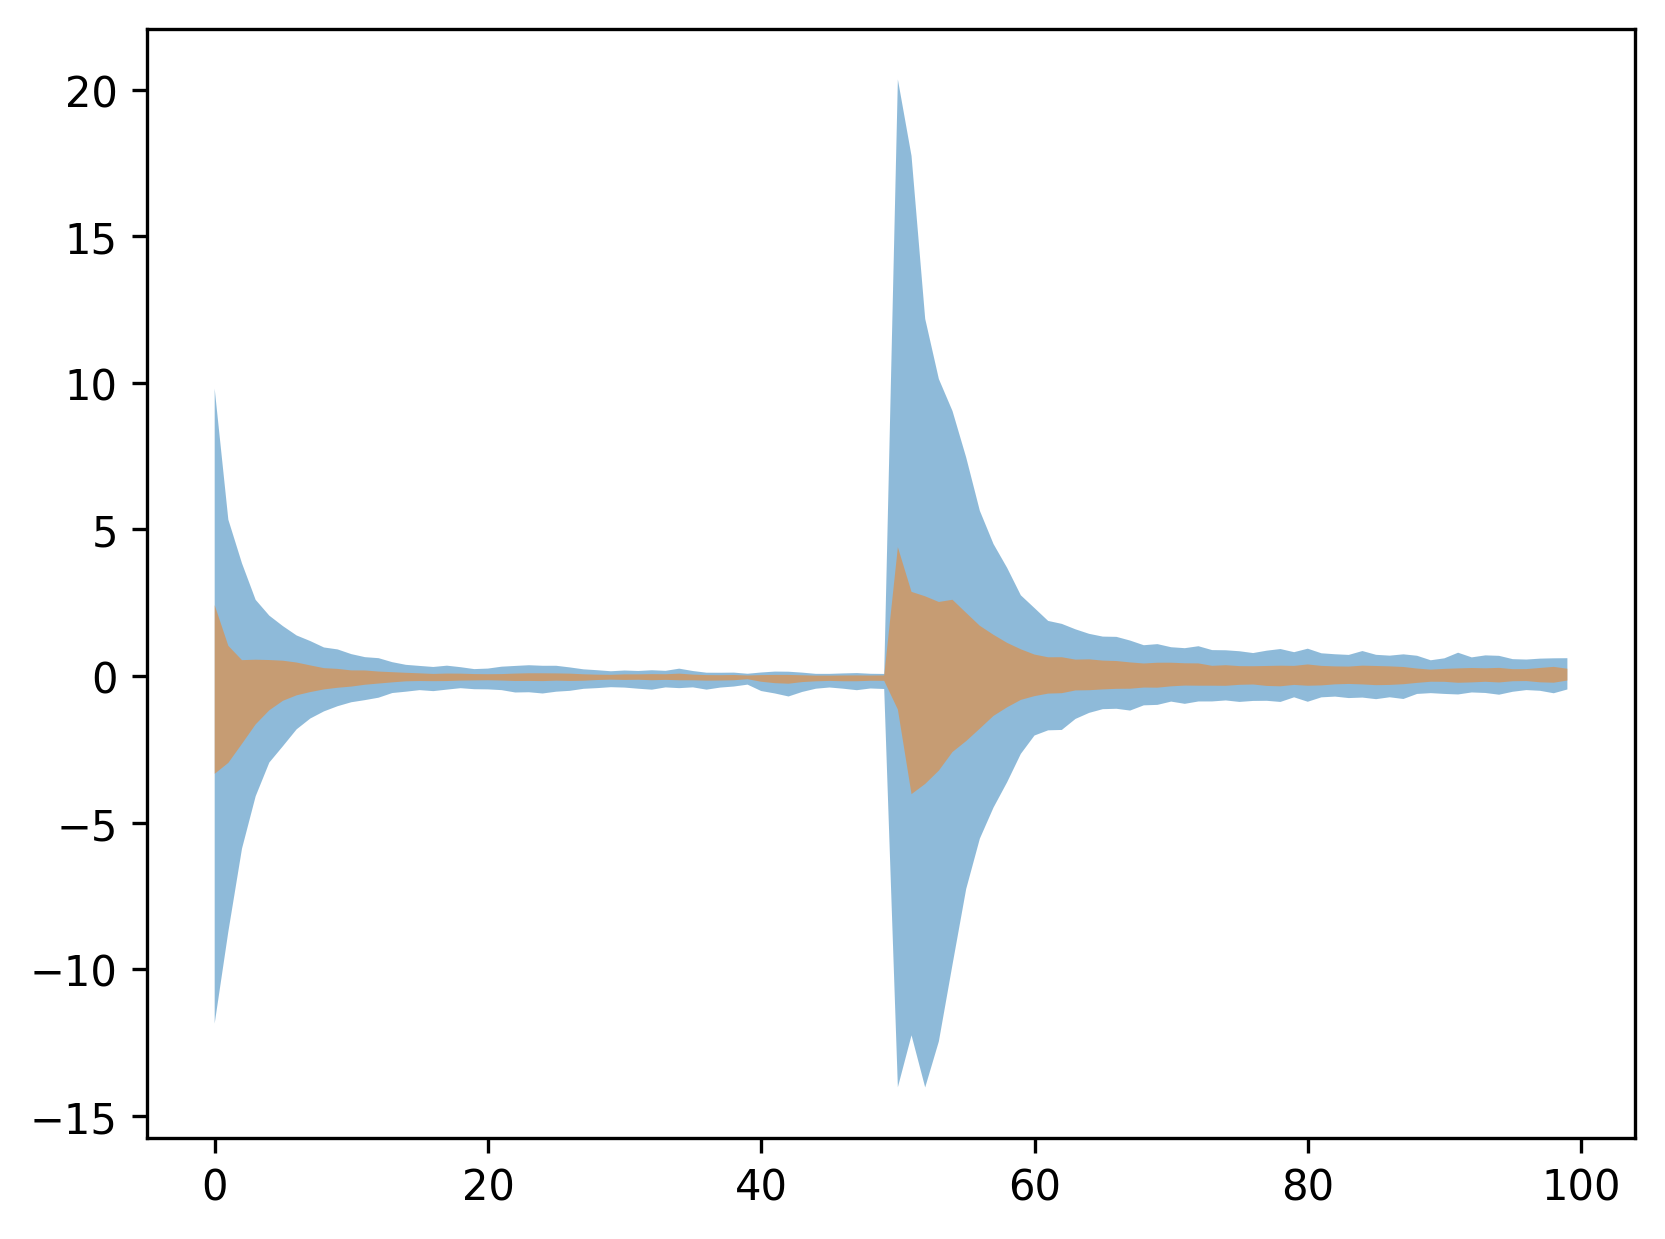

In [74]:

plt.fill_between(list(range(pred_test_y.shape[-1])), q95[0], q95[1], alpha=0.5, label='95\%',)
plt.fill_between(list(range(pred_test_y.shape[-1])), q68[0], q68[1], alpha=0.5, label='68\%',) 

In [75]:
from numpyro import distributions as dist
from sunbird.inference.hamiltonian import HMC

idx_fit = 0
priors = {
    'logM_cut': dist.Uniform(low=12.5, high=13.7),
    'logM_1': dist.Uniform(low=13.6, high=15.1),
    'sigma': dist.Uniform(low=-2.99, high=0.96),
    'alpha': dist.Uniform(low=0.3, high=1.48),
    'kappa': dist.Uniform(low=0., high=0.99),
    'alpha_c': dist.Uniform(low=0., high=0.61),
    'alpha_s': dist.Uniform(low=0.58, high=1.49),
    's': dist.Uniform(low=-0.98, high=1.),
    'A_cen': dist.Uniform(low=-0.99, high=0.93),
    'A_sat': dist.Uniform(low=-1., high=1.),
    'B_cen': dist.Uniform(low=-0.67, high=0.2),
    'B_sat': dist.Uniform(low=-0.97, high=0.99),
}
precision_matrix = np.linalg.inv(covariance_matrix)


In [76]:
dict(zip(lhc_x_names, lhc_test_x[idx_fit]))

{'logM_cut': 13.20083,
 'logM_1': 14.74781,
 'sigma': -1.54265,
 'alpha': 1.4767,
 'kappa': 0.02174,
 'alpha_c': 0.41098,
 'alpha_s': 0.63045,
 's': 0.93884,
 'A_cen': -0.28008,
 'A_sat': 0.29363,
 'B_cen': -0.27558,
 'B_sat': 0.23246}

In [77]:
hmc = HMC(
    observation=lhc_test_y[idx_fit],
    precision_matrix=precision_matrix,
    nn_theory_model = nn_model,
    nn_parameters = nn_params,
    priors=priors,
)

In [78]:
prior_samples = hmc.sanity_check_prior(n_samples=100)

Text(0, 0.5, '$r^2 \\xi(r)$')

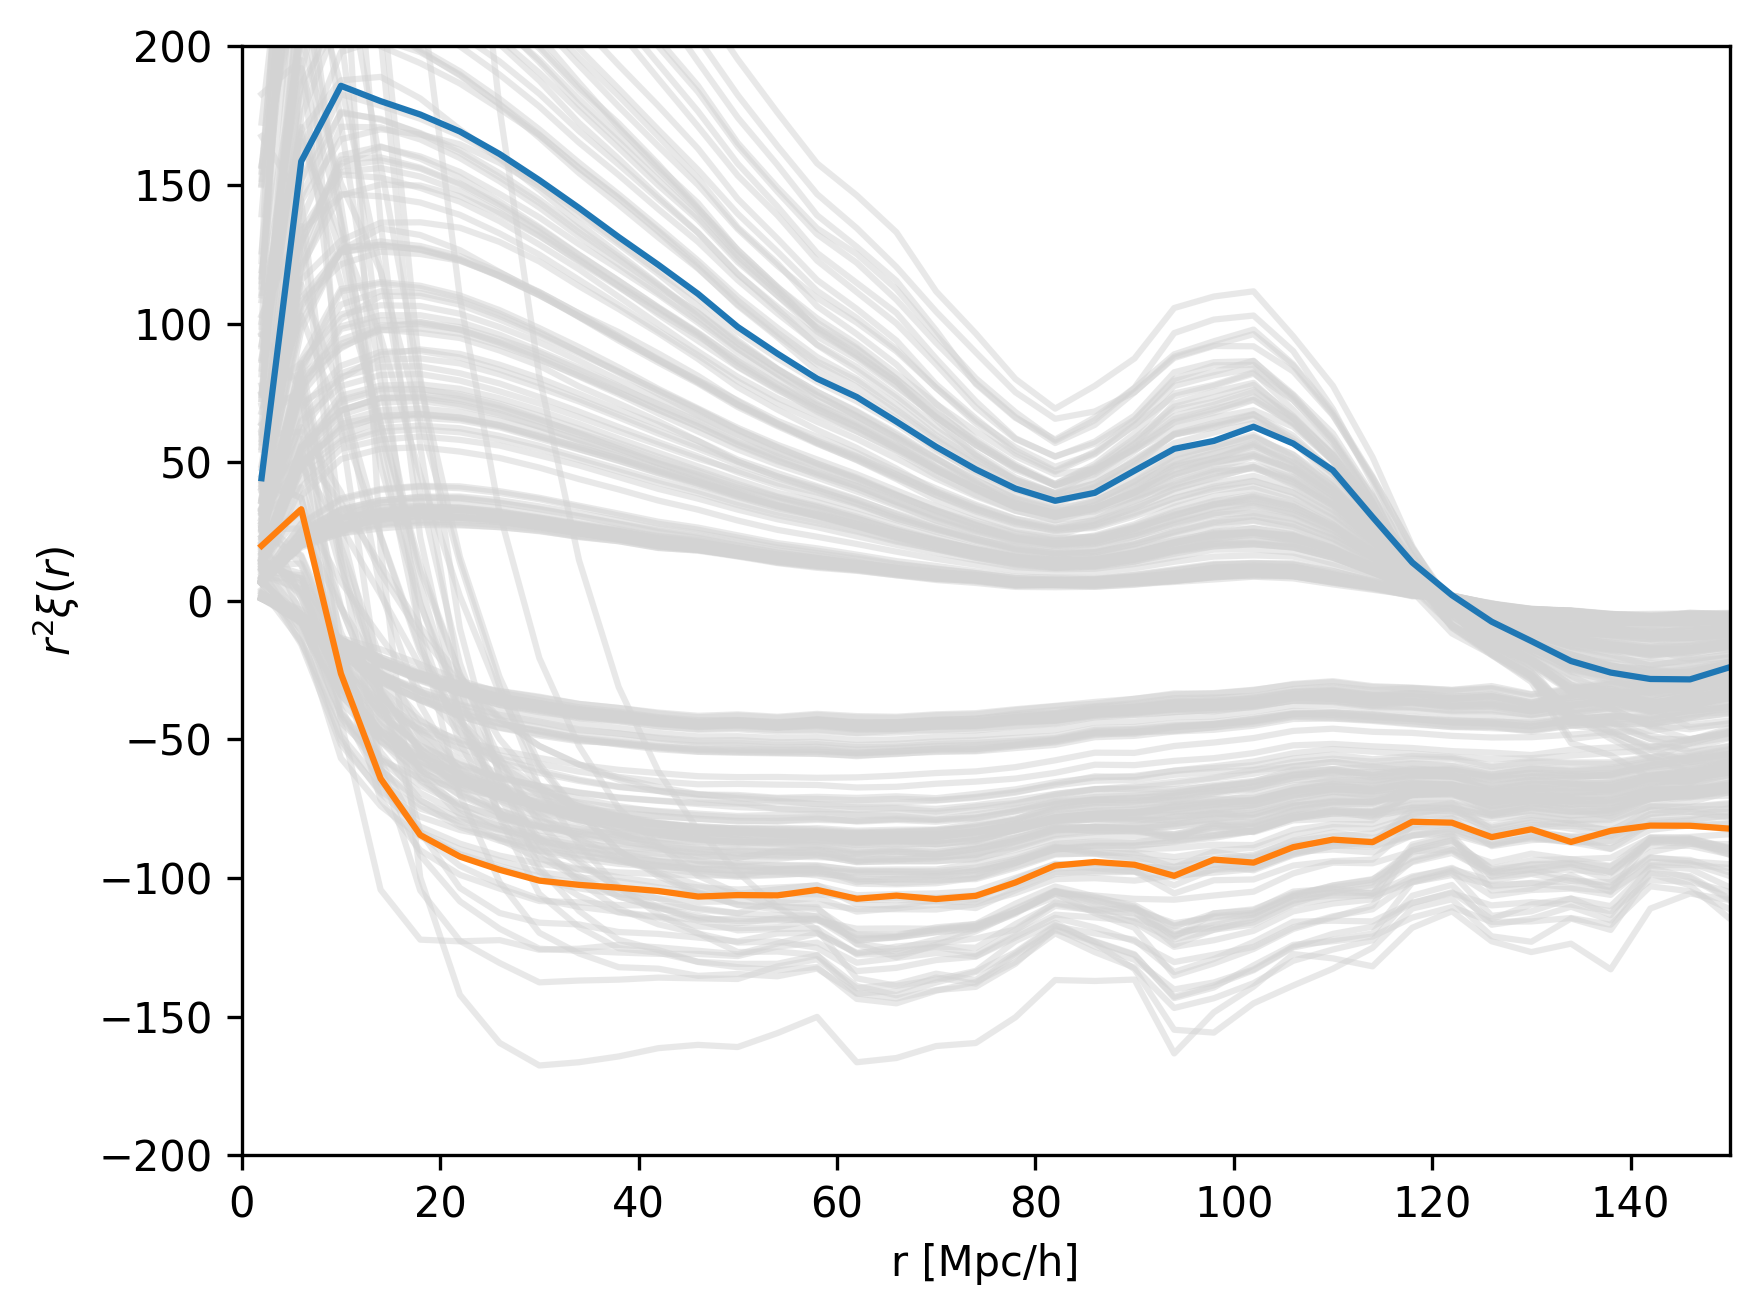

In [79]:

# let's plot some predictions vs truth
for i in range(len(prior_samples)):
    plt.plot(
        s,
        s**2*prior_samples[i][:50],
        color='lightgray',
        alpha=0.5,
    )
    plt.plot(
        s,
        s**2*pred_test_y[i][50:],
        color='lightgray',
        alpha=0.5,
    )

plt.plot(s, s**2*lhc_test_y[idx_fit,:50], label='Observed')
plt.plot(s, s**2*lhc_test_y[idx_fit,50:])


plt.xlim(0,150)
plt.ylim(-200,200)
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$r^2 \xi(r)$')

In [80]:
posterior = hmc()

sample: 100%|██████████| 1100/1100 [00:50<00:00, 21.58it/s, 127 steps of size 1.64e-02. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     A_cen      0.10      0.54      0.02     -0.73      0.93     11.29      1.07
     A_sat      0.48      0.60      0.77     -0.71      1.00     25.66      1.00
     B_cen     -0.28      0.02     -0.28     -0.31     -0.25     51.80      1.01
     B_sat      0.41      0.32      0.43     -0.06      0.95     52.73      1.02
     alpha      1.38      0.09      1.41      1.27      1.48     63.79      1.00
   alpha_c      0.40      0.01      0.40      0.37      0.41     33.58      1.00
   alpha_s      0.87      0.14      0.87      0.67      1.14     25.38      1.06
     kappa      0.32      0.26      0.23      0.00      0.78     36.52      1.00
    logM_1     14.88      0.10     14.88     14.72     15.04     39.72      1.01
  logM_cut     13.25      0.05     13.22     13.19     13.33     14.71      1.15
         s      0.44      0.46      0.58     -0.27      1.00     26.26      1.06
     sigma     -2.33      0

In [81]:
from getdist import plots, MCSamples
posterior_array = np.stack(list(posterior.values()), axis=0)
chain_getdist = MCSamples(
        samples=posterior_array.T,
        weights=np.ones(posterior_array.shape[-1]),
        names=list(posterior.keys()),
    )

Removed no burn in


In [82]:
from getdist import plots
g = plots.get_subplot_plotter()
g.settings.constrained_layout = True
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = ":"
g.settings.title_limit_labels = False
g.settings.axis_marker_color = "k"
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth_contour = 1.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 16
g.settings.axes_labelsize = 20
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6

g.triangle_plot(
    roots=[chain_getdist],
    filled=True,
    markers=dict(zip(lhc_x_names, lhc_test_x[idx_fit]))
)
plt.show()